In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Decision Paths Example

In [62]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.datasets import load_boston
from collections import defaultdict
import numpy as np



data = load_boston()
dt = DecisionTreeRegressor(max_depth=4)
# dt = RandomForestRegressor()

#Compute fature contributins on three samples. Use the rest of the data
#as training set
train = data.data[:-3]
target = data.target[:-3]
test = data.data[-3:]
actual = data.target[-3:]

dt.fit(train, target)
prediction = dt.predict(test)

#compute the decision paths from root to leaf for each sample
paths = dt.decision_paths(test)
contribution_list = []
for path in paths:
    contributions = defaultdict(int)
    for i in range(len(path)):
        if i == len(path) - 1 or path[i+1] == -1:
            break
        node_id = path[i]
        next_node_id = path[i+1]
        
        #feature contribution at a node is the difference of the mean of the 
        #decision node, and the mean at the following child node
        contributions[dt.tree_.feature[node_id]] += \
            dt.tree_.value[next_node_id][0][0] - dt.tree_.value[node_id][0][0]
    contribution_list.append(contributions)
  
print "Training set mean:", np.mean(target)
print
for i, contribs in enumerate(contribution_list):
    print "Prediction %s: %s " %(i + 1, prediction[i])
    print "Actual %s: %s " %(i+1, actual[i])
    print "Top five contributing features:"
    clist = sorted(contribs.items(), key = lambda x: -abs(x[1]))[:5]
    for key, val in clist:
        print data.feature_names[key], val
    print
    if i > 1:
        break
        

Training set mean: 22.5522862823

Prediction 1: 32.97 
Actual 1: 23.9 
Top five contributing features:
RM 9.74326927325
NOX 1.27825396825
DIS -0.60380952381

Prediction 2: 27.5277777778 
Actual 2: 22.0 
Top five contributing features:
LSTAT 3.45273170552
RM 1.96992924042
DIS -0.447169450465

Prediction 3: 21.6798969072 
Actual 3: 11.9 
Top five contributing features:
RM -3.87795163014
LSTAT 3.45273170552
DIS -0.447169450465



In [57]:
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot

# Print the tree
dot_data = StringIO()
tree.export_graphviz(dt, out_file=dot_data, 
                     feature_names=data.feature_names)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('paths_tree.pdf')

True

In [28]:
# Check value at non-terminal nodes
train_df = pd.DataFrame(train, columns=data.feature_names)
train_df['Value'] = target
print train_df.Value.mean()
print train_df.loc[train_df.RM <= 6.9410].Value.mean()
print train_df.loc[train_df.RM > 6.9410].Value.mean()

22.5522862823
19.9476635514
37.416



### Random Forest Interpretation

#### Build the Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_boston
import numpy as np

data = load_boston()
rf = RandomForestRegressor(n_estimators=100, random_state=1)

# Split into test_train
train, test, target, actual = train_test_split(
    data.data, data.target, test_size=.33, random_state=0)

# Fit the model
rf.fit(train, target)
prediction = rf.predict(test)

#### Compute Feature Importance

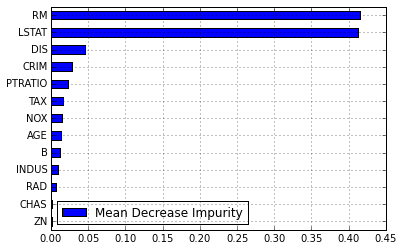

In [42]:
feat_scores = pd.DataFrame({'Mean Decrease Impurity' : rf.feature_importances_},index=data.feature_names)
feat_scores = feat_scores.sort('Mean Decrease Impurity')
feat_scores.plot(kind='barh')

#### Closer look at some similar observations

In [43]:
# Look for some similar examples
close_to_30 = abs(prediction - 30) < 1
prediction[close_to_30]

array([ 29.374,  29.072,  30.72 ,  29.801,  29.977,  29.478])

In [52]:
# Get raw data for these observations

out = pd.DataFrame(test[close_to_30].T, 
             index=data.feature_names)
out.columns = ['Observation ' + str(i+1) for i in range(out.shape[1])]
out.T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
Observation 1,9.23230,0,18.10,0,0.631,6.216,100.0,1.1691,24,666,20.2,366.15,9.53
Observation 2,8.26725,0,18.10,1,0.668,5.875,89.6,1.1296,24,666,20.2,347.88,8.88
Observation 3,0.03049,55,3.78,0,0.484,6.874,28.1,6.4654,5,370,17.6,387.97,4.61
Observation 4,0.04417,70,2.24,0,0.400,6.871,47.4,7.8278,5,358,14.8,390.86,6.07
Observation 5,0.06911,45,3.44,0,0.437,6.739,30.8,6.4798,5,398,15.2,389.71,4.69
Observation 6,0.49298,0,9.90,0,0.544,6.635,82.5,3.3175,4,304,18.4,396.90,4.54


#### Define function to find contributions

In [48]:
from collections import Counter, defaultdict

def rf_get_all_contributions(rf_model, y):
    contribution_full_list = []
    for t in y:
        contribution_list = []
        for tr in rf_model.estimators_:
            contributions = defaultdict(int)
            path = tr.decision_paths(t)[0]
            for i in range(len(path)):
                if i == len(path) - 1 or path[i+1] == -1:
                    break
                node_id = path[i]
                next_node_id = path[i+1]

            #feature contribution at a node is the difference of the mean of the 
            #decision node, and the mean at the following child node
                key = data.feature_names[tr.tree_.feature[node_id]]
                contributions[key] += \
                    tr.tree_.value[next_node_id][0][0] - tr.tree_.value[node_id][0][0]
            contribution_list.append(contributions)

        # Combine
        d = Counter()
        for contrib in contribution_list:
            d.update(contrib)

        # Normalize
        num_trees = len(rf.estimators_)
        for key, val in d.iteritems():
            d[key] = np.round(val / num_trees,2)
        contribution_full_list.append(d)
    return contribution_full_list


In [53]:
# Get contributions for all of the test data
all_contributions = rf_get_all_contributions(rf, test[close_to_30])

# Use a data frame to store the results
df_list = [pd.DataFrame(a, index=[i]) for i,a in enumerate(all_contributions)]
df = pd.concat(df_list).fillna(value=0)
df.index = ['Prediction ' + str(i+1) for i in df.index]
df

,AGE,B,CHAS,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,TAX,ZN
Prediction 1,-0.09,0.12,-0.02,0.53,6.11,0.10,2.67,-0.02,-0.19,0.06,-2.63,-0.20,0.03
Prediction 2,-0.07,0.04,0.05,0.63,6.22,0.16,2.56,-0.01,-0.19,0.06,-3.15,-0.16,0.03
Prediction 3,-0.01,-0.12,-0.05,0.05,-0.70,0.04,7.42,-0.11,0.42,-0.02,1.10,-0.14,-0.05
Prediction 4,0.04,-0.14,-0.02,-0.02,-0.53,0.25,3.50,0.16,1.46,0.13,2.21,-0.24,0.11
Prediction 5,0.17,-0.13,-0.02,-0.03,-0.68,0.15,7.86,0.03,0.85,0.01,-1.14,-0.16,0.18
Prediction 6,0.60,-0.05,-0.03,0.03,0.18,-0.26,8.62,-0.19,-0.02,-0.07,-1.83,-0.34,-0.05


### Cluster the predictions

In [36]:
# Get contributions for all of the test data
# all_contributions = rf_get_all_contributions(rf, test)
dat = data.data
all_contributions = rf_get_all_contributions(rf, dat)


# Use a data frame to store the results
df_list = [pd.DataFrame(a, index=[i]) for i,a in enumerate(all_contributions)]
df = pd.concat(df_list).fillna(value=0)

# Restrict to the top 5 features
df = df[feat_scores.index[-3:]]

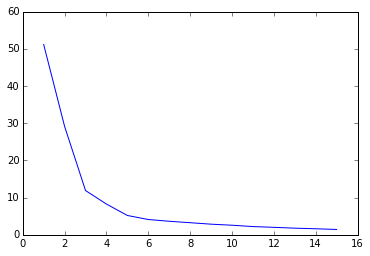

In [37]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

def kmeans_score(df,k):
    out = KMeans(n_clusters=k).fit(df)
    score = out.inertia_ / df.shape[0]
    return(score)

x = np.arange(15) + 1
y = [kmeans_score(df,k) for k in x]
plt.plot(x,y)

In [38]:
# Get 8 clusters
k = 10
clusters = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(df)
df['Mean Predicted Value'] = rf.predict(dat)
df['cluster_id'] = clusters.labels_
grouped = df.groupby('cluster_id')
out = grouped.mean().join(grouped.apply(lambda x: pd.Series({'Count' : len(x)})))
out = out.apply(lambda x: np.round(x,2))
out

,DIS,LSTAT,RM,Mean Predicted Value,Count
cluster_id,,,,,
0,0.34,-5.68,-1.55,16.70,107
1,-0.16,6.72,3.65,33.86,26
2,0.04,0.05,-2.47,20.45,112
3,0.11,5.41,16.19,44.62,30
4,-0.26,6.32,-3.87,25.05,63
5,-0.13,0.93,7.11,31.06,26
6,-0.14,2.70,-3.15,22.17,41
7,7.34,5.13,-2.64,34.84,5
8,-0.22,3.37,1.04,26.59,31
